In [9]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
y_test.shape, y_val.shape, y_train.shape
X_train.shape, X_train.dtype, X_val.shape, X_val.dtype, X_test.shape, X_test.dtype

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((55000, 784),
 dtype('float32'),
 (5000, 784),
 dtype('float32'),
 (10000, 784),
 dtype('float32'))

In [10]:
# Pre-processing
def prepro(X_train, X_val, X_test):
    mean = X_train.mean(axis=0) # mean on the number of training images
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return X_train - mean, X_val - mean, X_test - mean

X_train, X_val, X_test = prepro(X_train, X_val, X_test)

In [11]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        low, high = -1, 1
        
        # Input layer
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)

        # Hidden layers
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        
        # Output layer
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        # dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X):
        caches = []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y = l.sigmoid(X=y)
        X = y.copy() # pass to the next layer
        caches.append(fc_cache) # caches[0]
        
        # Hidden layers
        fc_caches = []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y = l.sigmoid(X=y)
            X = y.copy() # pass to next layer
            fc_caches.append(fc_cache)
        caches.append(fc_caches) # caches[1]
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        caches.append(fc_cache) # caches[2]

        return y, caches

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
    
    def train_backward(self, dy, caches):
        grads = []

        # Input layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        
        # Hidden layer
        grad = []
        for layer in range(self.L):
            grad.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        grads.append(grad)

        # Outout layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})

        # Output layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy() # pass to the previous layer
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches = caches[1]
        for layer in reversed(range(self.L)):
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache = caches[0]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_logit, _ = self.train_forward(X)
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy== acc
        y_pred = np.argmax(y_prob, axis=1) # for loss==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y, caches = self.train_forward(X_mini)
            loss, dy = self.loss_function(y, y_mini)
            _, grads = self.train_backward(dy, caches)
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val)
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [12]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 100 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 1 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.adam(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 2.2910 valid loss: 2.3300, valid accuracy: 0.0790
Iter-20 train loss: 2.3220 valid loss: 2.3294, valid accuracy: 0.0782
Iter-30 train loss: 2.3143 valid loss: 2.3290, valid accuracy: 0.0794
Iter-40 train loss: 2.2981 valid loss: 2.3286, valid accuracy: 0.0782
Iter-50 train loss: 2.2991 valid loss: 2.3281, valid accuracy: 0.0794
Iter-60 train loss: 2.3379 valid loss: 2.3276, valid accuracy: 0.0782
Iter-70 train loss: 2.3297 valid loss: 2.3272, valid accuracy: 0.0766
Iter-80 train loss: 2.3061 valid loss: 2.3266, valid accuracy: 0.0772
Iter-90 train loss: 2.3147 valid loss: 2.3264, valid accuracy: 0.0768
Iter-100 train loss: 2.2666 valid loss: 2.3260, valid accuracy: 0.0764
Iter-110 train loss: 2.3364 valid loss: 2.3255, valid accuracy: 0.0760
Iter-120 train loss: 2.3097 valid loss: 2.3250, valid accuracy: 0.0764
Iter-130 train loss: 2.3213 valid loss: 2.3246, valid accuracy: 0.0736
Iter-140 train loss: 2.3073 valid loss: 2.3244, valid accuracy: 0.0752
Iter-150 train 

Iter-1170 train loss: 2.2974 valid loss: 2.3085, valid accuracy: 0.0610
Iter-1180 train loss: 2.3039 valid loss: 2.3084, valid accuracy: 0.0608
Iter-1190 train loss: 2.3006 valid loss: 2.3084, valid accuracy: 0.0608
Iter-1200 train loss: 2.3131 valid loss: 2.3085, valid accuracy: 0.0606
Iter-1210 train loss: 2.3020 valid loss: 2.3085, valid accuracy: 0.0606
Iter-1220 train loss: 2.3030 valid loss: 2.3084, valid accuracy: 0.0610
Iter-1230 train loss: 2.3199 valid loss: 2.3084, valid accuracy: 0.0610
Iter-1240 train loss: 2.2947 valid loss: 2.3084, valid accuracy: 0.0606
Iter-1250 train loss: 2.3043 valid loss: 2.3084, valid accuracy: 0.0606
Iter-1260 train loss: 2.2960 valid loss: 2.3083, valid accuracy: 0.0608
Iter-1270 train loss: 2.3037 valid loss: 2.3083, valid accuracy: 0.0638
Iter-1280 train loss: 2.2962 valid loss: 2.3083, valid accuracy: 0.0652
Iter-1290 train loss: 2.3206 valid loss: 2.3082, valid accuracy: 0.0648
Iter-1300 train loss: 2.3025 valid loss: 2.3083, valid accuracy:

Iter-2310 train loss: 2.3001 valid loss: 2.3071, valid accuracy: 0.1128
Iter-2320 train loss: 2.3049 valid loss: 2.3071, valid accuracy: 0.1128
Iter-2330 train loss: 2.3112 valid loss: 2.3071, valid accuracy: 0.1128
Iter-2340 train loss: 2.2998 valid loss: 2.3071, valid accuracy: 0.1126
Iter-2350 train loss: 2.3045 valid loss: 2.3071, valid accuracy: 0.1128
Iter-2360 train loss: 2.3029 valid loss: 2.3071, valid accuracy: 0.1126
Iter-2370 train loss: 2.3081 valid loss: 2.3071, valid accuracy: 0.1128
Iter-2380 train loss: 2.3004 valid loss: 2.3071, valid accuracy: 0.1130
Iter-2390 train loss: 2.3015 valid loss: 2.3070, valid accuracy: 0.1128
Iter-2400 train loss: 2.3089 valid loss: 2.3070, valid accuracy: 0.1128
Iter-2410 train loss: 2.2935 valid loss: 2.3070, valid accuracy: 0.1128
Iter-2420 train loss: 2.3196 valid loss: 2.3070, valid accuracy: 0.1128
Iter-2430 train loss: 2.3086 valid loss: 2.3069, valid accuracy: 0.1126
Iter-2440 train loss: 2.3172 valid loss: 2.3069, valid accuracy:

Iter-3450 train loss: 2.3020 valid loss: 2.3059, valid accuracy: 0.1168
Iter-3460 train loss: 2.3072 valid loss: 2.3058, valid accuracy: 0.1166
Iter-3470 train loss: 2.3004 valid loss: 2.3058, valid accuracy: 0.1156
Iter-3480 train loss: 2.3065 valid loss: 2.3058, valid accuracy: 0.1160
Iter-3490 train loss: 2.3134 valid loss: 2.3058, valid accuracy: 0.1158
Iter-3500 train loss: 2.2940 valid loss: 2.3058, valid accuracy: 0.1158
Iter-3510 train loss: 2.3129 valid loss: 2.3058, valid accuracy: 0.1152
Iter-3520 train loss: 2.3054 valid loss: 2.3058, valid accuracy: 0.1140
Iter-3530 train loss: 2.2999 valid loss: 2.3057, valid accuracy: 0.1138
Iter-3540 train loss: 2.3065 valid loss: 2.3057, valid accuracy: 0.1140
Iter-3550 train loss: 2.3094 valid loss: 2.3057, valid accuracy: 0.1140
Iter-3560 train loss: 2.3060 valid loss: 2.3057, valid accuracy: 0.1134
Iter-3570 train loss: 2.2982 valid loss: 2.3057, valid accuracy: 0.1128
Iter-3580 train loss: 2.2953 valid loss: 2.3056, valid accuracy:

Iter-4590 train loss: 2.3193 valid loss: 2.3028, valid accuracy: 0.1126
Iter-4600 train loss: 2.3061 valid loss: 2.3027, valid accuracy: 0.1126
Iter-4610 train loss: 2.2846 valid loss: 2.3027, valid accuracy: 0.1126
Iter-4620 train loss: 2.2986 valid loss: 2.3027, valid accuracy: 0.1126
Iter-4630 train loss: 2.3051 valid loss: 2.3026, valid accuracy: 0.1126
Iter-4640 train loss: 2.3074 valid loss: 2.3026, valid accuracy: 0.1126
Iter-4650 train loss: 2.3006 valid loss: 2.3026, valid accuracy: 0.1126
Iter-4660 train loss: 2.3050 valid loss: 2.3025, valid accuracy: 0.1126
Iter-4670 train loss: 2.2957 valid loss: 2.3025, valid accuracy: 0.1126
Iter-4680 train loss: 2.2931 valid loss: 2.3025, valid accuracy: 0.1126
Iter-4690 train loss: 2.2947 valid loss: 2.3024, valid accuracy: 0.1126
Iter-4700 train loss: 2.3148 valid loss: 2.3024, valid accuracy: 0.1126
Iter-4710 train loss: 2.3133 valid loss: 2.3024, valid accuracy: 0.1126
Iter-4720 train loss: 2.3026 valid loss: 2.3023, valid accuracy:

Iter-5730 train loss: 2.2995 valid loss: 2.2967, valid accuracy: 0.1130
Iter-5740 train loss: 2.2877 valid loss: 2.2967, valid accuracy: 0.1130
Iter-5750 train loss: 2.2877 valid loss: 2.2966, valid accuracy: 0.1130
Iter-5760 train loss: 2.2933 valid loss: 2.2965, valid accuracy: 0.1130
Iter-5770 train loss: 2.3013 valid loss: 2.2965, valid accuracy: 0.1130
Iter-5780 train loss: 2.2930 valid loss: 2.2964, valid accuracy: 0.1130
Iter-5790 train loss: 2.2934 valid loss: 2.2963, valid accuracy: 0.1130
Iter-5800 train loss: 2.2922 valid loss: 2.2962, valid accuracy: 0.1130
Iter-5810 train loss: 2.2939 valid loss: 2.2962, valid accuracy: 0.1130
Iter-5820 train loss: 2.3058 valid loss: 2.2961, valid accuracy: 0.1130
Iter-5830 train loss: 2.3023 valid loss: 2.2960, valid accuracy: 0.1130
Iter-5840 train loss: 2.2984 valid loss: 2.2960, valid accuracy: 0.1130
Iter-5850 train loss: 2.3067 valid loss: 2.2959, valid accuracy: 0.1130
Iter-5860 train loss: 2.3021 valid loss: 2.2959, valid accuracy:

Iter-6870 train loss: 2.2916 valid loss: 2.2868, valid accuracy: 0.1200
Iter-6880 train loss: 2.2802 valid loss: 2.2867, valid accuracy: 0.1208
Iter-6890 train loss: 2.2881 valid loss: 2.2866, valid accuracy: 0.1214
Iter-6900 train loss: 2.2885 valid loss: 2.2865, valid accuracy: 0.1246
Iter-6910 train loss: 2.2891 valid loss: 2.2863, valid accuracy: 0.1236
Iter-6920 train loss: 2.2892 valid loss: 2.2862, valid accuracy: 0.1244
Iter-6930 train loss: 2.2777 valid loss: 2.2861, valid accuracy: 0.1244
Iter-6940 train loss: 2.3029 valid loss: 2.2860, valid accuracy: 0.1244
Iter-6950 train loss: 2.2924 valid loss: 2.2859, valid accuracy: 0.1240
Iter-6960 train loss: 2.2951 valid loss: 2.2858, valid accuracy: 0.1230
Iter-6970 train loss: 2.2752 valid loss: 2.2857, valid accuracy: 0.1232
Iter-6980 train loss: 2.2949 valid loss: 2.2856, valid accuracy: 0.1242
Iter-6990 train loss: 2.2969 valid loss: 2.2854, valid accuracy: 0.1254
Iter-7000 train loss: 2.2801 valid loss: 2.2853, valid accuracy:

Iter-8010 train loss: 2.2706 valid loss: 2.2718, valid accuracy: 0.1582
Iter-8020 train loss: 2.2783 valid loss: 2.2716, valid accuracy: 0.1584
Iter-8030 train loss: 2.2723 valid loss: 2.2715, valid accuracy: 0.1594
Iter-8040 train loss: 2.2682 valid loss: 2.2713, valid accuracy: 0.1622
Iter-8050 train loss: 2.2786 valid loss: 2.2711, valid accuracy: 0.1612
Iter-8060 train loss: 2.2748 valid loss: 2.2710, valid accuracy: 0.1610
Iter-8070 train loss: 2.2806 valid loss: 2.2708, valid accuracy: 0.1606
Iter-8080 train loss: 2.2678 valid loss: 2.2707, valid accuracy: 0.1602
Iter-8090 train loss: 2.2632 valid loss: 2.2705, valid accuracy: 0.1594
Iter-8100 train loss: 2.2666 valid loss: 2.2704, valid accuracy: 0.1582
Iter-8110 train loss: 2.2651 valid loss: 2.2702, valid accuracy: 0.1580
Iter-8120 train loss: 2.2575 valid loss: 2.2700, valid accuracy: 0.1596
Iter-8130 train loss: 2.2803 valid loss: 2.2698, valid accuracy: 0.1588
Iter-8140 train loss: 2.2746 valid loss: 2.2697, valid accuracy:

Iter-9150 train loss: 2.2517 valid loss: 2.2502, valid accuracy: 0.1946
Iter-9160 train loss: 2.2397 valid loss: 2.2500, valid accuracy: 0.1954
Iter-9170 train loss: 2.2387 valid loss: 2.2498, valid accuracy: 0.1958
Iter-9180 train loss: 2.2561 valid loss: 2.2496, valid accuracy: 0.1966
Iter-9190 train loss: 2.2335 valid loss: 2.2493, valid accuracy: 0.1950
Iter-9200 train loss: 2.2529 valid loss: 2.2491, valid accuracy: 0.1926
Iter-9210 train loss: 2.2595 valid loss: 2.2489, valid accuracy: 0.1942
Iter-9220 train loss: 2.2411 valid loss: 2.2487, valid accuracy: 0.1942
Iter-9230 train loss: 2.2523 valid loss: 2.2485, valid accuracy: 0.1956
Iter-9240 train loss: 2.2399 valid loss: 2.2482, valid accuracy: 0.1958
Iter-9250 train loss: 2.2725 valid loss: 2.2480, valid accuracy: 0.1976
Iter-9260 train loss: 2.2655 valid loss: 2.2478, valid accuracy: 0.1964
Iter-9270 train loss: 2.2497 valid loss: 2.2476, valid accuracy: 0.1954
Iter-9280 train loss: 2.2329 valid loss: 2.2473, valid accuracy:

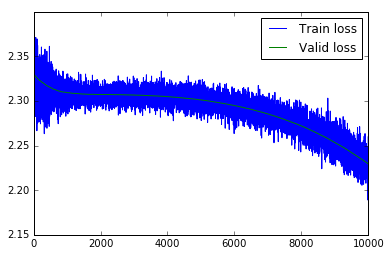

In [13]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

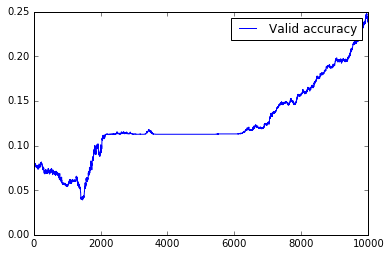

In [14]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()